## We use artificial data for the following two specifications of regression:

### Linear Regression

$ y(x) = a + b_1 \cdot X_1 + b_2 \cdot X_2 + b_3 \cdot X_3 + \sigma \cdot \varepsilon $ 

where $ \varepsilon \sim N(0, 1) $ is a Gaussian noise, and $ \sigma $ is its volatility, 
with the following choice of parameters:

$ a = 1.0 $

$ b_1, b_2, b_3 = (0.5, 0.2, 0.1) $

$ \sigma = 0.1 $

$ X_1, X_2, X_3 $ will be uniformally distributed in $ [-1,1] $

### Non-Linear Regression

$ y(x) = a + w_{00} \cdot X_1 + w_{01} \cdot X_2 + w_{02} \cdot X_3 + + w_{10} \cdot X_1^2 
+ w_{11} \cdot X_2^2 + w_{12} \cdot X_3^2 +  \sigma \cdot \varepsilon $ 

where

$ w = [[1.0, 0.5, 0.2],[0.5, 0.3, 0.15]]  $

and the rest of parameters is as above, with the same values of $ X_i $

In [1]:
!pip install sklearn --quiet

In [2]:
import numpy as np
import os
import math as m
import pandas as pd
import tensorflow.compat.v1 as tf

tf.disable_eager_execution()

import matplotlib
import matplotlib.pyplot as plt
!matplotlib inline

import time

/bin/sh: 1: matplotlib: not found


In [4]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [5]:
n_points = 5000
n_features = 3

bias = np.ones(n_points).reshape((-1,1))
low = - np.ones((n_points,n_features), 'float')
high = np.ones((n_points,n_features), 'float')

X = np.random.uniform(low=low, high=high)


noise = np.random.normal(size=(n_points, 1))

weights = np.array([1.0, 0.5, 0.2, 0.1])
noise_std = 0.1
Y = weights[0]*bias+np.dot(X, weights[1:]).reshape((-1,1))+noise_std+ noise

train_test_split = 4
n_test = int(n_points/train_test_split)
n_train = n_points - n_test

X_train = X[:n_train,:]
Y_train = Y[:n_train].reshape((-1,1))

X_test = X[n_train:,:]
Y_test = Y[n_train:].reshape((-1,1))

In [6]:
X_train.shape, Y_train.shape, X_test.shape

((3750, 3), (3750, 1), (1250, 3))

In [5]:
# Linear Regression with Numpy

X = np.hstack((np.ones(n_train).reshape((-1,1)), X_train))
theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y_train)

print(theta_numpy)

[[1.06639995]
 [0.51365092]
 [0.18902965]
 [0.13237374]]


In [11]:
# with SKlearn

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

print(np.r_[lin_reg.intercept_.reshape(-1,1), lin_reg.coef_.T])

[[1.06639995]
 [0.51365092]
 [0.18902965]
 [0.13237374]]


In [60]:
# with TF

X_np = np.hstack((np.ones(n_train).reshape((-1,1)), X_train))

X = tf.constant(X_np, dtype=tf.float32, name="X")
y = tf.constant(Y_train, dtype=tf.float32, name="Y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)),XT),y)

with tf.Session() as sess:
    theta_value = theta.eval()
    
theta_value

array([[ 8.1490725e-10,  2.5611371e-09, -2.9103830e-09],
       [ 1.0000001e+00,  1.0244548e-08,  9.8953024e-09],
       [ 4.0745363e-09,  9.9999994e-01, -2.0954758e-09],
       [ 1.0462827e-08, -4.4237822e-09,  1.0000000e+00]], dtype=float32)

In [10]:
# class

class Model:
    def __init__(self, n_features, learning_rate=0.05, L=0):
        self.X = tf.placeholder(tf.float32, [None, n_features], name="X")
        self.Y = tf.placeholder(tf.float32, [None, 1], name="Y")
        
        self.theta_in = tf.placeholder(tf.float32, [n_features+1, None])
        
        data_plus_bias = tf.concat([tf.ones([tf.shape(self.X)[0], 1]), self.X], axis=1)
        
        XT = tf.transpose(data_plus_bias)
        
        # normal equation for LR
        self.theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, data_plus_bias)), XT), self.Y)
        self.lr_mse = tf.reduce_mean(tf.square(tf.matmul(data_plus_bias, self.theta_in)-self.Y))
        
        # estimate model using the maximum likelihood estimation
        self.weights = tf.Variable(tf.random_normal([n_features+2, 1]))
        
        # prediction from the model
        self.output = tf.matmul(data_plus_bias, self.weights[:-1, :])
        gauss = tf.distributions.Normal(loc=0.0, scale=1.0)
        
        # standard deviation of the gaussian noise is modeled as a square of the last model weight
        sigma = 0.0001 + tf.square(self.weights[-1])
        
        pi = tf.constant(m.pi)
        log_LL = tf.log(0.00001 + (1/( tf.sqrt(2*pi)*sigma)) * gauss.prob((self.Y - self.output) / sigma ))  
        self.loss = -tf.reduce_mean(log_LL)
        
        # TF node defining an Op for on training set        
        self.train_step = (tf.train.AdamOptimizer(learning_rate).minimize(self.loss), self.loss)
        
    def generate_data(n_points = 10000, n_features = 3, weights = np.array([1.0, 0.5, 0.2, 0.1]), noise_std=0.1):
        bias = np.ones(n_points).reshape((-1,1))
        low = - np.ones((n_points, n_features), 'float')
        heigh=  np.ones((n_points, n_features), 'float')
        
        X = np.random.uniform(low=low, high=high)
        noise = np.random.normal(size=(n_points, 1))
        Y = weights[0] + bias + np.dot(X, weights[1:]).reshape((-1, 1)) + noise_std + noise
        
        return (X, Y)

In [11]:
def main():
    n_points = 5000
    n_features = 3
    learning_rate = 0.05
    
    weights = np.array([1.0, 0.5, 0.2, 0.1])
    noise_std = 0.1
    
    (X, Y) = Model.generate_data(n_points=n_points, n_features=n_features, weights = weights, noise_std=noise_std)
    
    n_test = int(n_points/4)
    n_train = n_points - n_test

    X_train = X[:n_train,:]
    Y_train = Y[:n_train].reshape((-1,1))

    X_test = X[n_train:,:]
    Y_test = Y[n_train:].reshape((-1,1))
    
    print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
    
    model = Model(n_features=n_features, learning_rate=learning_rate)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        theta_value = sess.run(model.theta, feed_dict={
            model.X: X_train,
            model.Y: Y_train
        })
        
        lr_mse_train = sess.run(model.lr_mse, feed_dict={
            model.X: X_train,
            model.Y: Y_train,
            model.theta_in: theta_value
        })
        
        lr_mse_test = sess.run(model.lr_mse, feed_dict={
            model.X: X_test,
            model.Y: Y_test,
            model.theta_in: theta_value
        })
        
        print("=== Linear Regression with the Normal Equation ====")
        print(theta_value)
        print("Linear regression train error: ", lr_mse_train)
        print("Linear regression test error: ", lr_mse_test)
        
        for i in range(0, 1000):
            (_, loss), weights = sess.run((model.train_step, model.weights), feed_dict = {
                model.X: X_train,
                model.Y: Y_train
            })
            
        Y_test_predicted = sess.run(model.output, feed_dict = {
            model.X: X_test
        })
        
        std_model = weights[-1]**2
        
        print("=== Linear Regression with Maximum Likelihood Estimation ===")
        print("Negative log-likelihood: ", loss)
        print("MLE fitted parameters: \n", weights[0:-1])
        print("Fitted std of noise: ", std_model)
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(X_test[:, 1], X_test[:,2], Y_test, s = 1, c="#000000")
        ax.scatter(X_test[:, 1], X_test[:,2], Y_test_predicted, s = 1, c="#FF0000")
        plt.show()
        
        sess.close()

(3750, 3) (3750, 1) (1250, 3) (1250, 1)
=== Linear Regression with the Normal Equation ====
[[2.1186423 ]
 [0.4807228 ]
 [0.18679689]
 [0.09666888]]
Linear regression train error:  1.0013599
Linear regression test error:  0.8972297
=== Linear Regression with Maximum Likelihood Estimation ===
Negative log-likelihood:  2.338329
MLE fitted parameters: 
 [[2.1186135 ]
 [0.4809364 ]
 [0.18699254]
 [0.09658721]]
Fitted std of noise:  [0.999972]


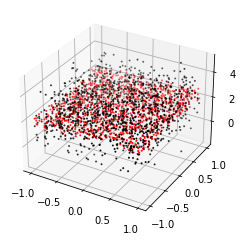

In [12]:
if __name__ == "__main__":
    main()